<a href="https://colab.research.google.com/github/amirarasteh1990/Examples/blob/main/Mikkel_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## INSTALL ALL REQUIRED PACKAGES
import importlib
if not importlib.util.find_spec("py_wake"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git
if not importlib.util.find_spec("topfarm"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git
if not importlib.util.find_spec("ed_win"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git@dev2#egg=ed_win[interarray]

  Cloning https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git to /tmp/pip-req-build-_63_ahz8
  Running command git clone --filter=blob:none --quiet https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git /tmp/pip-req-build-_63_ahz8
  Resolved https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git to commit 34f823df45af3b55ce34e624d7da5dea1454ceff
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.6 MB/s eta 0:00:00
  Created wheel for py_wake: filename=py_wake-2.5.1.dev64+g34f823d-py3-none-any.whl size=97196520 sha256=2d223006ef7e7db90ca5cce37228785aec0f028d2ddbea994e3dcf3f2f9fa4ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-hhzpg65h/wheels/eb/a5/d1/e7380004c5b927c92dd3bfb3a466983ecefc2e7119756db77d
Successfully built py_wake

In [ ]:
!pip install fastkml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pygeoif: filename=pygeoif-0.7-py3-none-any.whl size=19000 sha256=1df810a501a1b387a61da21a2a0ed3033f414374f2d7b711cb9f9f91328f1249
  Stored in directory: /root/.cache/pip/wheels/22/24/2c/811afb826232cb08e23a7a5e889bcf1edf3dd12ed37914b7d1
Successfully built pygeoif


In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import zipfile
import xarray as xr
from fastkml import kml
import utm

from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine
from py_wake.site.xrsite import GlobalWindAtlasSite, XRSite
from py_wake.deficit_models.gaussian import BastankhahGaussian
from py_wake.utils.gradients import autograd

from ed_win.wind_farm_network import WindFarmNetwork

from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation
from topfarm._topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.plotting import XYPlotComp
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm import SpacingConstraint, XYBoundaryConstraint
from topfarm.constraint_components.boundary import InclusionZone, ExclusionZone
from topfarm.easy_drivers import EasySimpleGADriver
from topfarm.recorders import TopFarmListRecorder
from topfarm.easy_drivers import EasyScipyOptimizeDriver

/usr/local/lib/python3.10/dist-packages/py_wake/deficit_models/gaussian.py:124: UserWarning: The BastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014')


Solving with heuristic(cpew)



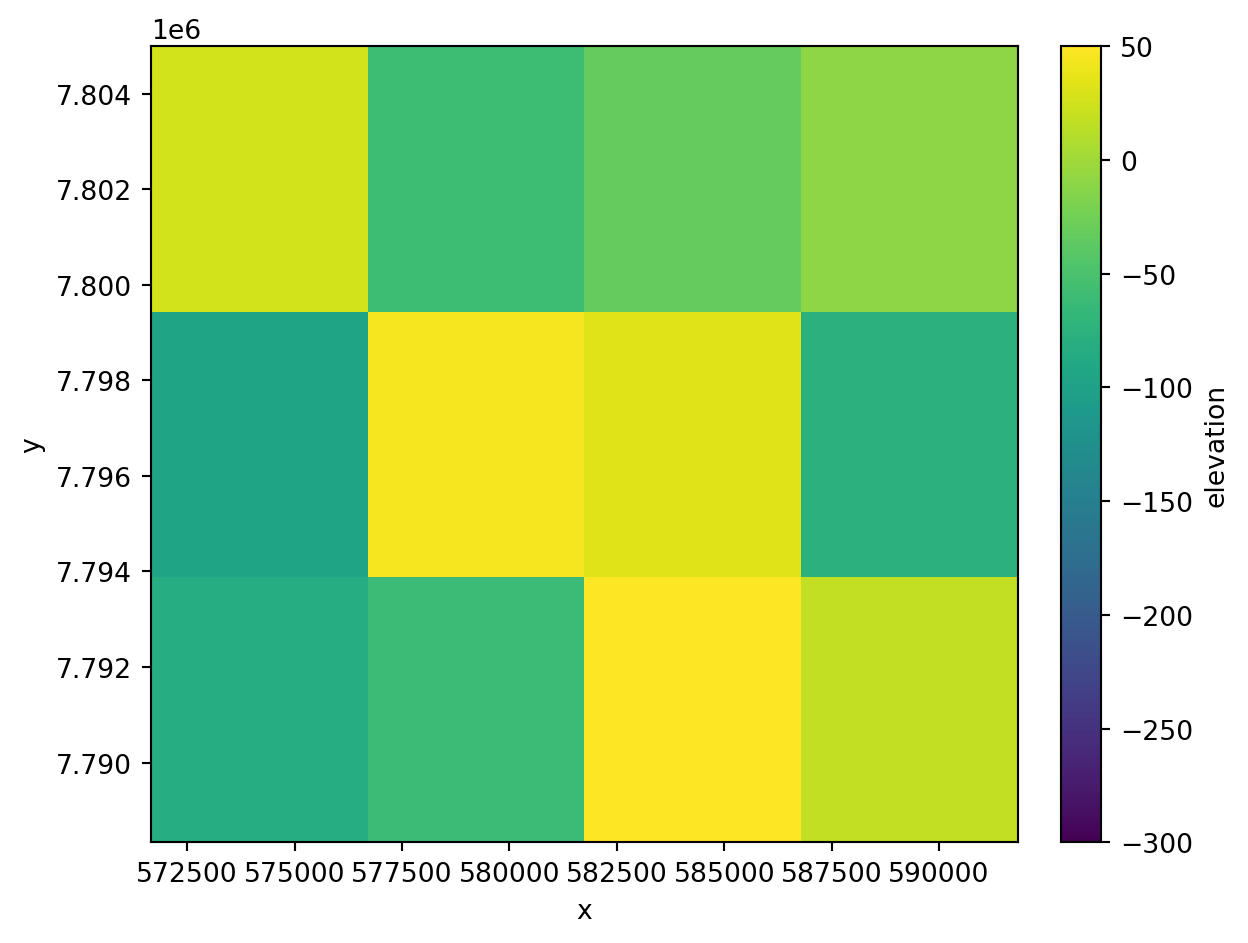

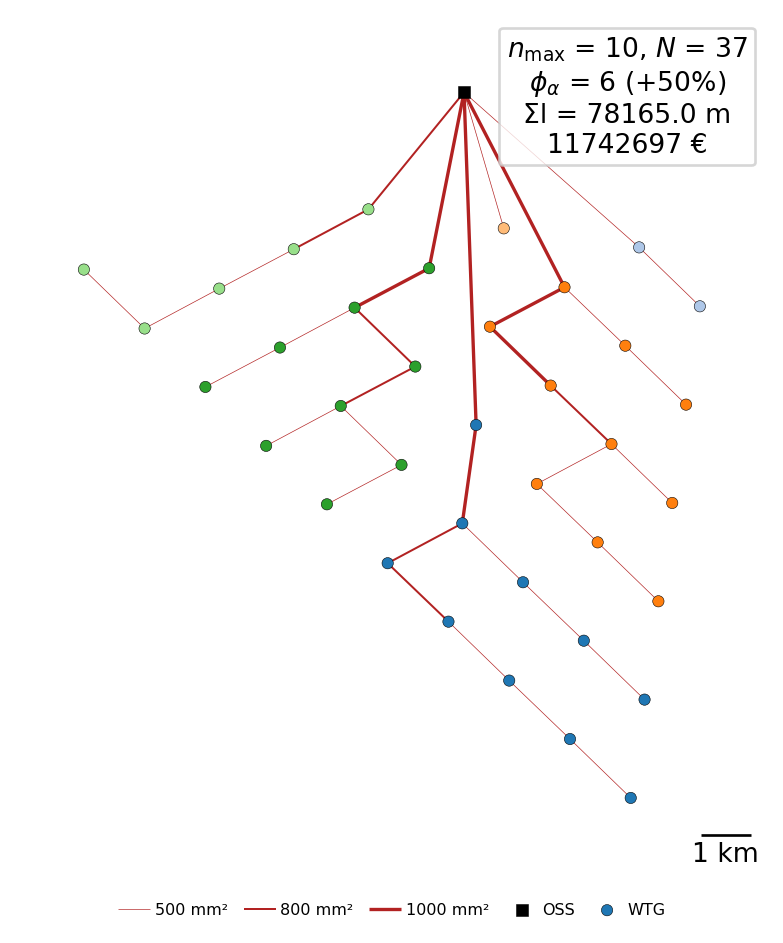

In [ ]:
plt.close('all')
# %% Global inputs
n_wt = 37
lat_ref = -19.95
lon_ref = 57.78125
hh = 106.7
power_ref = 7000 # kw
diameter_ref = 154
YO = 25

# %% Wind Turbine Model
wt = GenericWindTurbine('G7MW', diameter_ref, hh, power_norm=power_ref, turbulence_intensity=.1)

# %% Site

try:
    site = XRSite.load('data/ref_site.nc')
except:
    site = GlobalWindAtlasSite(lat_ref, lon_ref, hh, 0.0002, ti=0.1)
    site.save('data/ref_site.nc')

# %% boundary

zones = [InclusionZone(np.array([[ 588089.57227018, 7799172.95735365],
       [ 588088.9158143 , 7799041.67870399],
       [ 588036.51131201, 7798896.54563371],
       [ 587826.49611364, 7798897.59403813],
       [ 587825.11653205, 7798620.92401939],
       [ 587301.73988245, 7798623.52615367],
       [ 587296.2527936 , 7797516.84640896],
       [ 586249.56684077, 7797522.00616742],
       [ 586246.85521795, 7796968.66691914],
       [ 585985.1922769 , 7796969.9473996 ],
       [ 585983.84033518, 7796693.27779531],
       [ 585722.18163581, 7796694.55451769],
       [ 585719.48549474, 7796141.2153479 ],
       [ 584672.88488173, 7796146.28437739],
       [ 584671.55303358, 7795869.61520851],
       [ 584409.90730934, 7795870.87286528],
       [ 584404.5947816 , 7794764.19595372],
       [ 584142.9656527 , 7794765.4502417 ],
       [ 584141.64123946, 7794488.7809543 ],
       [ 582833.5180389 , 7794494.99462076],
       [ 582825.69182917, 7792834.98118966],
       [ 581517.69529487, 7792841.10130966],
       [ 581513.84191229, 7792011.09547977],
       [ 580990.66887747, 7792013.51700243],
       [ 580989.39235504, 7791736.84849226],
       [ 580727.81014025, 7791738.05353107],
       [ 580726.53758851, 7791461.38507014],
       [ 579941.80402751, 7791464.97716603],
       [ 579939.28321499, 7790911.64076397],
       [ 579677.71384692, 7790912.8305782 ],
       [ 579676.45733897, 7790636.16238644],
       [ 579414.89221376, 7790637.34842392],
       [ 579413.63968092, 7790360.68027926],
       [ 578890.51803272, 7790363.04089791],
       [ 578889.27360274, 7790086.37292272],
       [ 578366.16067168, 7790088.71818106],
       [ 578364.9243465 , 7789812.05037368],
       [ 577318.71637173, 7789816.69455559],
       [ 577317.49640867, 7789540.02715545],
       [ 577055.94882758, 7789541.17856602],
       [ 577053.86475269, 7789067.01775632],
       [ 577047.58585172, 7789073.89151176],
       [ 576922.02978305, 7789162.72518643],
       [ 576108.37186506, 7789934.15169183],
       [ 575560.39956068, 7790221.79260575],
       [ 575552.14960341, 7790234.61368577],
       [ 575294.67031319, 7790499.46098601],
       [ 575253.08838637, 7790568.7288769 ],
       [ 575220.36774893, 7790609.30748835],
       [ 575203.05960781, 7790593.69029226],
       [ 574547.68343449, 7791267.75498217],
       [ 574583.17048196, 7791311.43863649],
       [ 574541.88550823, 7791348.95352945],
       [ 574478.78108876, 7791389.4933439 ],
       [ 574485.52478453, 7791398.50424051],
       [ 574431.79892628, 7791443.47535948],
       [ 574419.77042051, 7791427.4028508 ],
       [ 574346.98441929, 7791474.16136882],
       [ 574152.74100205, 7791673.92156764],
       [ 574133.7521185 , 7791686.78395259],
       [ 573878.87248115, 7791798.640316  ],
       [ 573032.65409903, 7792344.83897176],
       [ 573023.42135379, 7792348.9610167 ],
       [ 572205.3148518 , 7792627.18563141],
       [ 572179.32737993, 7792633.41238979],
       [ 572016.94810483, 7792643.12446138],
       [ 571887.34166046, 7792704.7453511 ],
       [ 571361.52426886, 7793096.63127627],
       [ 571355.09153752, 7793099.86676449],
       [ 570637.94577438, 7793298.6936107 ],
       [ 570599.04698226, 7793317.18354266],
       [ 570570.61193427, 7793319.90552938],
       [ 570379.1605002 , 7793391.35501548],
       [ 570418.69256591, 7793566.40765074],
       [ 570419.16772143, 7793572.69163716],
       [ 570360.67173205, 7794392.9655427 ],
       [ 570366.00648645, 7794609.21964241],
       [ 570336.87718745, 7794726.60208087],
       [ 570305.92493819, 7795160.57645604],
       [ 570265.62357273, 7795265.60209721],
       [ 570263.85952701, 7795291.84996637],
       [ 570253.56364578, 7795336.60629843],
       [ 570262.23601873, 7795391.80411404],
       [ 570416.19397716, 7795366.3571833 ],
       [ 571113.1772625 , 7795447.17778517],
       [ 571514.85284453, 7795430.57810463],
       [ 571524.87642346, 7795432.57361048],
       [ 573096.4569358 , 7796056.17655692],
       [ 574375.33474492, 7797206.17652203],
       [ 575209.97466949, 7798746.36758169],
       [ 575215.34872289, 7798762.05942983],
       [ 575295.53165662, 7799243.63549782],
       [ 575378.5830663 , 7799457.08274958],
       [ 575392.80847637, 7799510.77311015],
       [ 575572.42314849, 7801014.92623619],
       [ 575540.01265775, 7801215.03936664],
       [ 575540.47457257, 7801218.0643431 ],
       [ 575540.26668946, 7801225.74554997],
       [ 575524.74729844, 7801309.29094984],
       [ 575382.56522711, 7802187.09761393],
       [ 575358.99096983, 7802461.13574711],
       [ 575269.08396465, 7802685.47120735],
       [ 575231.04750756, 7802890.19228478],
       [ 575066.77027293, 7803190.25929658],
       [ 574793.9368624 , 7803870.947055  ],
       [ 574794.98483811, 7803871.59284403],
       [ 574790.19734343, 7803880.27630376],
       [ 574771.74973548, 7803926.29872176],
       [ 574746.59211006, 7803969.11158678],
       [ 574258.68519428, 7804662.12170363],
       [ 574236.33718924, 7804688.85311121],
       [ 574187.50280869, 7804643.24438985],
       [ 574117.89673934, 7804728.74804812],
       [ 574155.10922412, 7804763.47023117],
       [ 574120.51899429, 7804804.88299636],
       [ 573951.15314968, 7804933.57019189],
       [ 573850.6136962 , 7805057.06627124],
       [ 574800.933996  , 7804703.37776642],
       [ 575770.78535509, 7804398.46754846],
       [ 576379.2971654 , 7804240.3620366 ],
       [ 576430.24141082, 7804232.49489366],
       [ 576493.81401962, 7804197.80934662],
       [ 576576.41438985, 7804142.64990637],
       [ 576665.44169499, 7804100.20680505],
       [ 576830.88949929, 7804047.23545189],
       [ 576914.19193447, 7804032.32549756],
       [ 576961.00108041, 7803547.59477201],
       [ 576973.04435075, 7803476.07322181],
       [ 577004.1578926 , 7803481.94143158],
       [ 577038.87714875, 7803016.48559902],
       [ 577707.01710223, 7801426.21077541],
       [ 577765.58022217, 7801333.26828179],
       [ 579100.37996095, 7799915.2681594 ],
       [ 579233.03938058, 7799820.85860259],
       [ 579569.66164139, 7799601.72096217],
       [ 579640.79045984, 7799559.52263509],
       [ 580044.12148929, 7799345.55855846],
       [ 580113.60605165, 7799312.86107161],
       [ 580616.50500358, 7799110.57026131],
       [ 580651.8215615 , 7799098.67770749],
       [ 580724.19911069, 7799081.51611441],
       [ 580806.45464168, 7799039.60734007],
       [ 580893.36480293, 7799011.28667662],
       [ 581600.47460045, 7798840.54751748],
       [ 581661.63424218, 7798830.76865976],
       [ 582167.97238049, 7798791.4639917 ],
       [ 582226.11354281, 7798777.72897031],
       [ 582267.65652565, 7798774.74611383],
       [ 582305.82479366, 7798780.76059444],
       [ 582407.98286605, 7798772.82793844],
       [ 582475.36486899, 7798773.07695754],
       [ 583662.254537  , 7798932.57905382],
       [ 583711.17066331, 7798945.74874778],
       [ 583698.1057982 , 7799000.09442495],
       [ 584333.15659428, 7799100.09935401],
       [ 584377.03919506, 7799117.75132629],
       [ 585131.36964702, 7799502.46391481],
       [ 585169.8005482 , 7799526.56345619],
       [ 585216.05788115, 7799555.16793679],
       [ 585615.30466806, 7799916.03542138],
       [ 585987.82267217, 7800140.13226125],
       [ 586358.33958593, 7800543.37328416],
       [ 586371.91455938, 7800527.88574676],
       [ 586410.24725743, 7800565.43642103],
       [ 586653.33998233, 7800820.91143534],
       [ 586701.37668104, 7800875.06969051],
       [ 586752.63183508, 7800962.49036457],
       [ 586789.46751295, 7801004.7869267 ],
       [ 586785.7032582 , 7801008.44993613],
       [ 586945.67999959, 7801182.53515547],
       [ 586968.30904051, 7801215.3701015 ],
       [ 587198.7898067 , 7801595.92407058],
       [ 587424.0881127 , 7801846.73349127],
       [ 587439.94882529, 7801874.01257676],
       [ 587933.99262235, 7803015.20252335],
       [ 588152.69717841, 7804248.58867992],
       [ 588155.14145094, 7804289.34738956],
       [ 588145.76139592, 7804387.49222087],
       [ 588176.28324801, 7804738.67762942],
       [ 588566.08291675, 7805189.36185301],
       [ 588578.09491084, 7805208.34798599],
       [ 588679.79143898, 7805449.02126361],
       [ 588748.85442205, 7805437.79465007],
       [ 588986.45757391, 7805290.02310457],
       [ 589027.96518624, 7805180.20096038],
       [ 589087.52770005, 7805112.34883795],
       [ 589132.58703527, 7805075.15932349],
       [ 589215.26074132, 7805040.96625802],
       [ 589300.63135343, 7805036.07401409],
       [ 589859.13917582, 7805085.49923235],
       [ 589936.93739472, 7805095.29989136],
       [ 589979.13321246, 7805121.85091103],
       [ 589994.62235765, 7805160.00903786],
       [ 589987.21531626, 7805207.20586035],
       [ 589951.85265036, 7805271.11462597],
       [ 589914.02493593, 7805351.60564134],
       [ 589911.68336212, 7805392.40422805],
       [ 589927.16608414, 7805429.2884475 ],
       [ 589962.98338919, 7805454.59791456],
       [ 590098.05391548, 7805447.53682208],
       [ 590382.01281276, 7805393.828632  ],
       [ 590541.10997556, 7805349.67826161],
       [ 590703.76834448, 7805254.52506179],
       [ 590812.84201135, 7805149.44971256],
       [ 590855.50775666, 7805019.22462454],
       [ 590892.6288561 , 7804802.35955247],
       [ 590897.61964527, 7804286.15029888],
       [ 590900.14812148, 7803415.66926444],
       [ 590878.86526023, 7803242.45505172],
       [ 590834.6437759 , 7803069.36059591],
       [ 590631.00016473, 7802624.36603897],
       [ 590450.92484304, 7802300.32419479],
       [ 590391.87475997, 7802216.5190149 ],
       [ 590298.27515698, 7802104.85522572],
       [ 590185.71195078, 7802022.59852148],
       [ 589887.54796639, 7801778.8111512 ],
       [ 589860.32044861, 7801687.19878416],
       [ 589874.04539373, 7801629.78466396],
       [ 589924.7697287 , 7801581.10228189],
       [ 590035.21551188, 7801498.98316104],
       [ 590047.67846527, 7801444.12452622],
       [ 590033.21917203, 7801357.54612535],
       [ 589972.91934026, 7801277.57352034],
       [ 589874.32763325, 7801185.05348   ],
       [ 589632.27708527, 7800946.72235362],
       [ 589304.03466727, 7800545.72568105],
       [ 589122.23502724, 7800375.89939445],
       [ 588978.98575533, 7800269.58895014],
       [ 588760.51079763, 7800153.46343664],
       [ 588559.68498629, 7799999.02167823],
       [ 588409.83181163, 7799844.96059749],
       [ 588321.21959176, 7799706.51997452],
       [ 588216.45163703, 7799394.87624791],
       [ 588136.23424763, 7799172.72396636],
       [ 588089.57227018, 7799172.95735365]])),
         ExclusionZone(np.array([[ 583096.62791072, 7800311.99408867],
                [ 574926.00180347, 7799219.41537019],
                [ 581754.06751367, 7793647.03581502],
                [ 583096.62791072, 7800311.99408867]])),]

xybound = XYBoundaryConstraint(zones, boundary_type='multi_polygon')

# %% Bathymetry
# Define the dimensions for the dataset
lat_size = 10
lon_size = 10
# Define coordinate ranges (you may adjust these ranges as needed)
lat_range = np.linspace(-20.1757, -19.7239, lat_size)
lon_range = np.linspace(57.5642, 57.9982, lon_size)

# Generate elevation data (for demonstration, we'll create a grid of values)
elevation_data = np.random.uniform(low=-100, high=50, size=(lat_size, lon_size))

# Create a dataset using Xarray
ds = xr.Dataset(
    {'elevation': (['lat', 'lon'], elevation_data)},
    coords={'lat': lat_range, 'lon': lon_range}
)

# bxy = np.asarray([utm.from_latlon(lat, long,force_zone_letter='K', force_zone_number=40)[:2] for lat, long in zip(ds.lat.values, ds.lon.values)])
bx = np.asarray([utm.from_latlon(lat_ref, lon, force_zone_letter='K', force_zone_number=40)[0] for lon in ds.lon.values])
by = np.asarray([utm.from_latlon(lat, lon_ref, force_zone_letter='K', force_zone_number=40)[1] for lat in ds.lat.values])
# ds.add_co
ds2 = xr.Dataset({'elevation': (["x", "y"], ds.elevation.values.T),
                  },
                coords={"x": bx, "y": by})

x_min = 570253.5636457754
x_max = 590900.1481214832
y_min = 7789067.017756319
y_max = 7805454.597914555


ds3 = ds2.where(ds2.x>=x_min-1000, drop=True)
ds3 = ds3.where(ds2.x<=x_max+1000, drop=True)
ds3 = ds3.where(ds2.y>=y_min-1000, drop=True)
ds3 = ds3.where(ds2.y<=y_max+1000, drop=True)

ds3.elevation.plot(vmin=-300, vmax=50)

def water_depth(x, y, **kwargs):
    return - ds3.elevation.interp(dict(x=x, y=y), method='linear').values.diagonal()

wd_ref = water_depth(np.linspace(x_min, x_max, n_wt), n_wt * [7.797e6])


# %% initial turbine positions

# %% array cables
ss_x = [497620.7]
ss_y = [5730622.0]
wt_x = [500968.1461, 499748.6565, 501245.7744, 500026.2848,
                         498527.8286, 497308.339, 501523.4027, 500303.9131,
                         498805.4569, 497585.9673, 496087.5111, 494868.0215,
                         501801.031, 500581.5414, 499083.0852, 497863.5956,
                         496365.1394, 495145.6498, 493647.1936, 492427.704,
                         502078.6593, 500859.1697, 499360.7135, 498141.2239,
                         496642.7677, 495423.2781, 493924.8219, 492705.3323,
                         491206.8762, 489987.3865, 502356.2876, 501136.798,
                         499638.3418, 498418.8522, 496920.396, 495700.9064,
                         494202.4502]
wt_y = [5716452.784, 5717635.848, 5718427.22, 5719610.283,
                         5718809.394, 5719992.458, 5720401.656, 5721584.719,
                         5720783.83, 5721966.894, 5721166.004, 5722349.068,
                         5722376.092, 5723559.155, 5722758.266, 5723941.33,
                         5723140.44, 5724323.504, 5723522.615, 5724705.678,
                         5724350.528, 5725533.591, 5724732.702, 5725915.765,
                         5725114.876, 5726297.94, 5725497.051, 5726680.114,
                         5725879.225, 5727062.288, 5726324.963, 5727508.027,
                         5726707.138, 5727890.201, 5727089.312, 5728272.376,
                         5727471.486]

cables = np.array([[500, 3, 100], [800, 5, 150], [1000, 10, 250]])

plt.plot(wt_x, wt_y, '2k')
# pd.read
n_wt = len(wt_x)

# %% wake model
wf_model = BastankhahGaussian(site, wt)
aep = wf_model(wt_x, wt_y).aep().sum().values
CF = aep / (power_ref*1e-6 * 24*365*n_wt)

wfn = WindFarmNetwork(wt_x=wt_x, wt_y=wt_y, ss_x=ss_x, ss_y=ss_y, cables=cables)
G = wfn.optimize()
cable_cost_ref = G.cost # euro
cable_length_ref = G.length  # m
cost_per_length_ref = cable_cost_ref / cable_length_ref # euro / m

G.plot()

# %% financial model
Drotor_vector = [wt.diameter()] * n_wt
power_rated_vector = [float(wt.power(20))*1e-6] * n_wt
hub_height_vector = [wt.hub_height()] * n_wt

In [ ]:
# add additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
distance_from_shore = 30         # [km]
energy_price = 0.2               # [Euro/kWh] What we get per kWh
project_duration = 20            # [years]
rated_rpm_array = [12] * n_wt    # [rpm]
water_depth_array = [15] * n_wt  # [m]
eco_eval = economic_evaluation(distance_from_shore, energy_price, project_duration)
npv_ref = eco_eval.calculate_npv(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth_array, aep/n_wt * np.ones(n_wt)*10**6, cabling_cost=cable_cost_ref)
irr_ref = eco_eval.calculate_irr(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth_array, aep/n_wt * np.ones(n_wt)*10**6, cabling_cost=cable_cost_ref)

# %%  SETUP OF WRAPPER FUNCTIONS


def cable_func(x, y, x_substation, y_substation, **kwargs):
    G = wfn.optimize(turbines_pos= np.asarray([x, y]).T, substations_pos=np.asarray([[float(x_substation)], [float(y_substation)]]).T)
    return G.size(weight="cost"), {'cabling_length': G.size(weight="length")}

def ss_dist_2(x, y, x_substation, y_substation, **kwargs):
    return (x - x_substation) ** 2 + (y - y_substation) ** 2

def ss_dist_2_grad(x, y, x_substation, y_substation, **kwargs):
    return [2 *(x - x_substation), -2*(x - x_substation), 2 *(y - y_substation), -2*(y - y_substation)]

def npv_func(AEP, water_depth, cabling_cost, **kwargs):
    eco_eval.calculate_npv(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth, AEP/n_wt * np.ones(n_wt)*10**6, cabling_cost=cabling_cost)
    eco_eval.calculate_irr(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth, AEP/n_wt * np.ones(n_wt)*10**6, cabling_cost=cabling_cost)
    CAPEX = eco_eval.project_costs_sums["CAPEX"]
    OPEX = eco_eval.project_costs_sums["OPEX"]
    return eco_eval.NPV, {'irr': eco_eval.IRR,
                          'OPEX': OPEX,
                          'CAPEX': CAPEX,}

def lcoe_func(CAPEX, OPEX, AEP, **kwargs):
    return (CAPEX + OPEX * YO) / (YO * AEP) * 10**-3 # Euro / MWh

def opex_func(CAPEX, LCOE, AEP, **kwargs):
    return LCOE * AEP * 10**3 - CAPEX / YO # Euro / year


def wf_area_func(x, y, **kwargs):
    hull = ConvexHull(list(np.asarray([x, y]).T))
    return hull.volume


def plot_recorder(recorder):
    xs = recorder['timestamp'] - recorder['timestamp'][0]
    AEP = recorder['AEP']
    water_depth = recorder['water_depth'].mean((1))
    cabling_cost = recorder['cabling_cost']
    cabling_length = recorder['cabling_length']
    irr = recorder['irr'] / recorder['irr'][0]
    npv = recorder['npv'] / recorder['npv'][0]
    fig = plt.figure()
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(333)
    ax4 = fig.add_subplot(334)
    ax5 = fig.add_subplot(335)
    ax6 = fig.add_subplot(336)
    ax7 = fig.add_subplot(337)
    ax8 = fig.add_subplot(338)
    ax9 = fig.add_subplot(339)
    ax1.title.set_text('AEP [GWh]')
    ax2.title.set_text('Mean Water Depth [m]')
    ax3.title.set_text('Cabling Cost [€]')
    ax4.title.set_text('cabling Length [m]')
    ax5.title.set_text('Relative IRR [-]')
    ax6.title.set_text('Relative NPV [-]')
    ax7.title.set_text('Relative NPV [-]')
    ax8.title.set_text('Relative NPV [-]')
    ax9.title.set_text('Relative NPV [-]')
    ax1.plot(xs, AEP)
    ax2.plot(xs, water_depth)
    ax3.plot(xs, cabling_cost)
    ax4.plot(xs, cabling_length)
    ax5.plot(xs, irr)
    ax6.plot(xs, npv)
    ax7.plot(xs, npv)
    ax8.plot(xs, npv)
    ax9.plot(xs, npv)
    plt.show()
    plt.tight_layout()

# %% SETUP OF COMPONENTS

x_init = wt_x
y_init = wt_y
x_ss_init = 5.77e5
y_ss_init = 7.79e6

aep_component = PyWakeAEPCostModelComponent(wf_model, n_wt, grad_method=autograd, objective=False)

water_depth_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                          n_wt=n_wt,
                                          cost_function=water_depth,
                                          objective=False,
                                          output_keys=[('water_depth', np.zeros(n_wt))])

cable_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init), ('x_substation', x_ss_init), ('y_substation', y_ss_init)],
                                     n_wt=n_wt,
                                     cost_function=cable_func,
                                     objective=False,
                                     output_keys=[('cabling_cost', 100000)],
                                     additional_output=[('cabling_length', 10000)])

ss_dist_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init), ('x_substation', x_ss_init), ('y_substation', y_ss_init)],
                                     n_wt=n_wt,
                                     cost_function=ss_dist_2,
                                     cost_gradient_function=ss_dist_2_grad,
                                     objective=False,
                                     output_keys=[('ss_dist', np.zeros(n_wt))],)

npv_comp = CostModelComponent(input_keys=[('AEP', 0), ('water_depth', 30*np.ones(n_wt)), ('cabling_cost', 100000)],
                              n_wt=n_wt,
                              cost_function=npv_func,
                              objective=True,
                              maximize=True,
                              output_keys=[('npv', 0)],
                              additional_output=[('irr', 0),
                                                 ('CAPEX', 0),
                                                 ('OPEX', 0)])

lcoe_comp = CostModelComponent(input_keys=[('CAPEX', 0), ('OPEX', 0), ('AEP', 0)],
                              n_wt=n_wt,
                              cost_function=lcoe_func,
                              objective=False,
                              output_keys=[('lcoe', 0)])

wf_area_comp = CostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                              n_wt=n_wt,
                              cost_function=wf_area_func,
                              objective=False,
                              output_keys=[('area', 0)])

cost_comp = TopFarmGroup([aep_component, water_depth_component,ss_dist_component, cable_component, npv_comp, lcoe_comp, wf_area_comp])

# %% SETUP OF PROBLEM

problem = TopFarmProblem(design_vars={'x': (x_init,x_min,x_max), 'y': (y_init,y_min,y_max), 'x_substation': (x_ss_init, x_min, x_max), 'y_substation': (y_ss_init, y_min, y_max)},
                  cost_comp=cost_comp,
                  driver=EasySimpleGADriver(max_gen=2000, pop_size=1000, Pm=None, Pc=.5, elitism=True, bits={}),
                  constraints=[xybound,
                              SpacingConstraint(4 * wt.diameter()),
                              ('ss_dist', {'lower': np.ones(n_wt) * 4 * wt.diameter()})],
                  plot_comp=XYPlotComp())

100%|██████████| 2/2 [00:00<00:00, 300.23it/s]

INFO: checking out_of_order



INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


In [ ]:
# %% eval
cost_ref, state_ref = problem.evaluate()

# %% optimize
optimize = False
if optimize:
    cost, state, recorder = problem.optimize()
    t = datetime.datetime.now()
    time_stamp = t.strftime('%Y_%m_%d_%H_%M')
    recorder.save(time_stamp + '_GA')
else:
    recorder = TopFarmListRecorder().load('recordings/2024_04_25_23_05_GA.pkl')


# %% SETUP OF PROBLEM

problem = TopFarmProblem(design_vars={'x': (x_init,x_min,x_max), 'y': (y_init,y_min,y_max), 'x_substation': (x_ss_init, x_min, x_max), 'y_substation': (y_ss_init, y_min, y_max)},
                  cost_comp=cost_comp,
                  driver = EasyScipyOptimizeDriver('SLSQP', maxiter=250),
                  constraints=[xybound,
                              SpacingConstraint(4 * wt.diameter())],
                  plot_comp=XYPlotComp(),
                  expected_cost=1e2)

INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings
<ipython-input-28-a049aff74149>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G = wfn.optimize(turbines_pos= np.asarray([x, y]).T, substations_pos=np.asarray([[float(x_substation)], [float(y_substation)]]).T)


Solving with heuristic(cpew)



LinAlgError: 'cost_comp.comp_4' <class CostModelComponent>: Error calling compute(), Array must not contain infs or NaNs

/usr/local/lib/python3.10/dist-packages/py_wake/deficit_models/gaussian.py:124: UserWarning: The BastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014')


Solving with heuristic(cpew)



100%|██████████| 2/2 [00:00<00:00, 268.77it/s]

INFO: checking out_of_order



INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings
<ipython-input-26-144b7bdcaa9c>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G = wfn.optimize(turbines_pos= np.asarray([x, y]).T, substations_pos=np.asarray([[float(x_substation)], [float(y_substation)]]).T)


Solving with heuristic(cpew)



LinAlgError: 'cost_comp.comp_4' <class CostModelComponent>: Error calling compute(), Array must not contain infs or NaNs

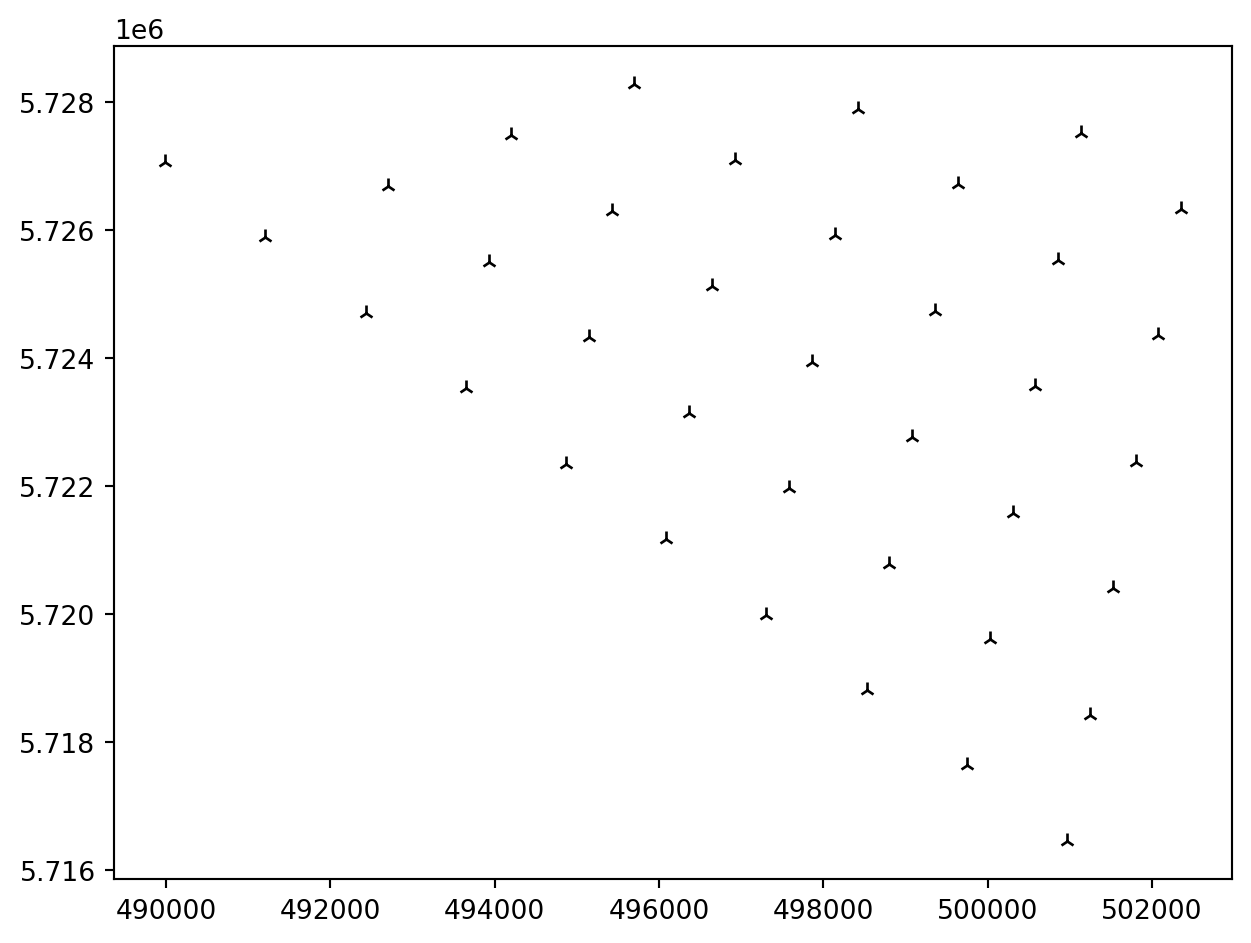

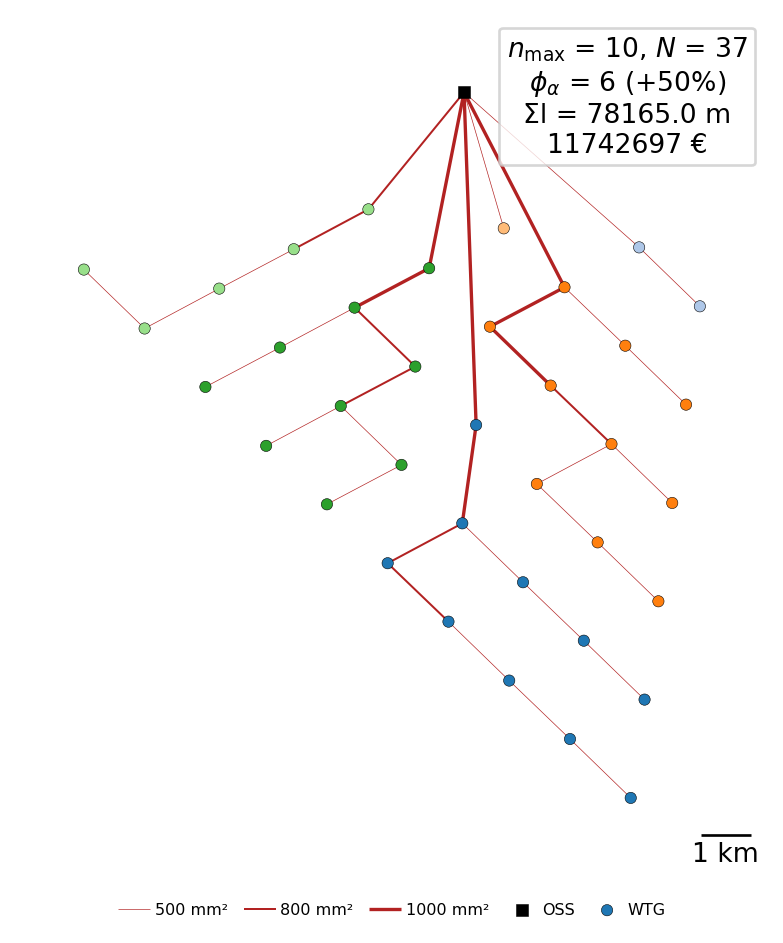

In [ ]:
# problem.driver.options['debug_print'] = ['desvars','ln_cons','nl_cons','objs','totals']
# %% optimize
optimize = True

if optimize:
    cost, state, recorder = problem.optimize()
    t = datetime.datetime.now()
    time_stamp = t.strftime('%Y_%m_%d_%H_%M')
    recorder.save(time_stamp + '_SLSQP')
else:
    recorder = TopFarmListRecorder().load('recordings/2024_04_26_10_02_SLSQP.pkl')
plot_recorder(recorder)
x_opt = recorder['x'][-1]
y_opt = recorder['y'][-1]
G = wfn.optimize(np.asarray([recorder['x'][-1], recorder['y'][-1]]).T,
                 substations_pos=np.asarray([[float(recorder['x_substation'][-1])], [float(recorder['y_substation'][-1])]]).T,
                 )
G.plot()
aep_no_wake = wf_model(x_opt, y_opt).aep(with_wake_loss=False).sum()
aep = wf_model(x_opt, y_opt).aep(with_wake_loss=True).sum()
wl = (aep - aep_no_wake) / aep_no_wake * 100

